This notebook is used to produce the plots appearing in Figure 7.A and several figures of the supporting information of artcile doi:10.1021/acs.jctc.4c00294 

# Modules

In [15]:
# Basics
import sys
import os
import numpy as np
import pandas as pd
from typing import List, Tuple

# Visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm


# Specific to biomolecular simulations
import MDAnalysis as mda

# My functions
import functions as myfuncs

# Charge Data

In [16]:
# Load the data
my_path = "../Examples/"
my_name = "A_HairpinRibozyme_REST2_traj"

df = pd.read_csv(my_path + my_name + ".csv")

In [17]:
data_names = [
    "d_A-1:O2prime-G8:N1",
    "d_A-1:O2prime-A10:N6",
    "d_A-1:O2prime-A38:N6",
    "d_A-1:O2prime-G+1:O1P",
    "d_A-1:O2prime-G+1:O2P",
    "d_G+1:O1P-G8:N2",
    "d_G+1:O2P-G8:N2",
    "A-1_puckering_pseudorot",
    "IAA",
]

long_names = [
    "A-1:O2' - G8:N1",
    "A-1:O2' - A10:N6",
    "A-1:O2' - A38:N6",
    "A-1:O2'- G+1:pro-Sp",
    "A-1:O2' - G+1:pro-Rp",
    "G+1:pro-Sp - G8:N2",
    "G+1:pro-Rp - G8:N2",
    "A-1 pseudo-rotation (°)",
    "IAA (°)",
]

# Generate Ordered H-Bonds


In [18]:
# Define the start and end time (in picoseconds)
start_time: int = 300000  # in ps
end_time: int = 0  # in ps

Performing the analysis of the trajectory over the time range from 300000 ps to 672600.0 ps
Analysis complete: found 781 unique combinations
Shannon entropy: 7.2055 bits
Showed: 60.15834675254965%; Unshowed: 39.84165324745035%


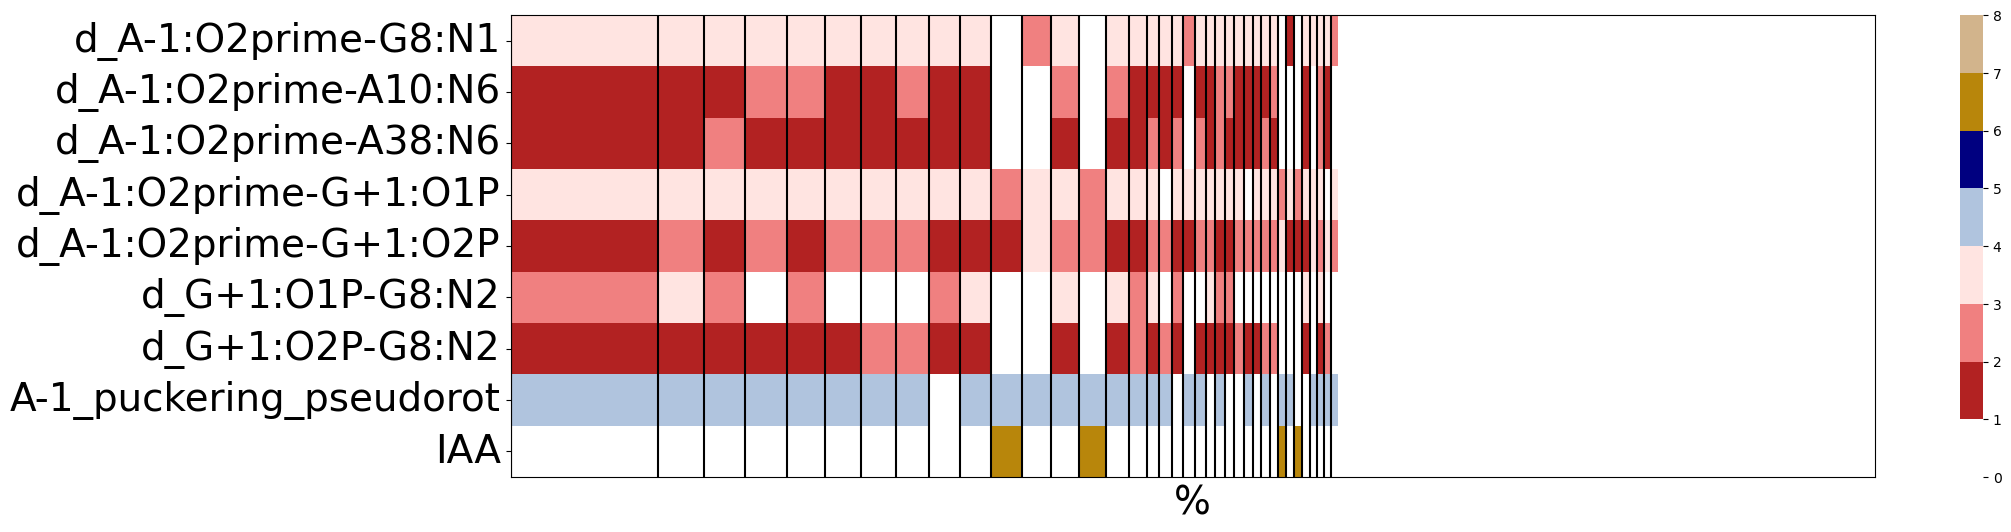

In [19]:
# Define custom colors for the heatmap
custom_colors: List[str] = [
    "white",
    "firebrick",
    "lightcoral",
    "mistyrose",
    "lightsteelblue",
    "navy",
    "darkgoldenrod",
    "tan",
]
custom_cmap = ListedColormap(custom_colors)

# Extract time from the dataframe
time_series: pd.Series = df["Time"]
time_step: int = int(time_series[1])  # Assuming uniform time steps
start_frame: int = int(start_time / time_step)

# Define end frame based on the provided or default time range
if end_time != 0:
    end_frame: int = int(end_time / time_step)
else:
    end_frame = len(time_series) - 1

# Display the time range of the analysis
print(
    f"Performing the analysis of the trajectory over the time range from {start_time} ps to {time_series[end_frame]} ps"
)

# Extract data for the specified variables and store them in an array
data_array: List[np.ndarray] = []
for data_name in data_names:
    data_values = df[data_name].values
    data_array.append(data_values[start_frame:end_frame])

# Categorize the data array based on the provided function
categorized_data: np.ndarray = myfuncs.categorize_data_array(data_array, data_names)
num_frames, num_data_columns = np.shape(categorized_data)

# Perform clustering on the categorized data
combinations: np.ndarray = myfuncs.cluster_data_combinations(categorized_data)

# Convert combinations to a DataFrame for further processing
df_combinations = pd.DataFrame(
    np.array(combinations), columns=["Indexes", "Counts", "Frames"]
)

# Calculate entropy of the distribution
entropy: float = myfuncs.calculate_distribution_entropy(df_combinations, num_frames)

# Sort the data by the "Counts" column in descending order
df_combinations = df_combinations.sort_values("Counts", ascending=False)

# Generate a colored DataFrame based on the distribution of counts
colored_fp_df_tr, x_axis_positions, k_value = myfuncs.generate_colored_dataframe(
    df_combinations, data_names, num_frames, cutoff=0.005
)


# Create the plot
fig, ax = plt.subplots(figsize=(22, 6))

# Plot the heatmap
sns.heatmap(ColoredFP_df_tr, cmap=custom_cmap, vmin=0, vmax=8)
mask = np.triu(np.ones_like(ColoredFP_df_tr, dtype=bool))

# Add vertical lines for X-axis positions
for x_position in x_axis_positions:
    ax.axvline(x=x_position, color="black")

# Set the plot frame visibility
for spine in ax.spines.values():
    spine.set_visible(True)

# Define custom ticks and labels for the X-axis
tick_positions: List[float] = []
tick_labels: List[float] = []
showed_percentage: float = 0
for t in range(1, k_value):
    tick_position = (
        x_axis_positions[t] - x_axis_positions[t - 1]
    ) / 2 + x_axis_positions[t - 1]
    tick_positions.append(tick_position)

    tick_label = round(
        (x_axis_positions[t] - x_axis_positions[t - 1]) / num_frames * 100, 1
    )
    tick_labels.append(tick_label)

    showed_percentage += (
        (x_axis_positions[t] - x_axis_positions[t - 1]) / num_frames * 100
    )

print(f"Showed: {showed_percentage}%; Unshowed: {100 - showed_percentage}%")

# Remove X-tick labels as they are not needed
ax.set_xticks([])
ax.set_xticklabels([])

# Set Y-axis tick parameters
ax.tick_params(axis="y", labelsize=28)

# Set X-axis label and adjust its position
x_axis_label_text: str = "%"
ax.set_xlabel(x_axis_label_text, fontsize=28)
ax.xaxis.set_label_coords(0.5, -0.015)  # Adjust the coordinates for positioning

# Save the plot to a file
output_file_path: str = (
    f"{my_path}{my_name}_ORDERED_Hbondfingerprints_{start_frame}-{end_frame}.png"
)
plt.savefig(output_file_path, dpi=300, bbox_inches="tight")

# Display the plot
plt.show()